<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/STABiLSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/crop_production_dataset.csv')
data = data.drop(columns=["Production"])
data.columns = data.columns.str.strip()
missing_values = data.isnull().sum()

# Print missing values for each column
print(missing_values)

State        0
District     0
Crop         9
Crop_Year    0
Season       0
Area         0
Yield        0
dtype: int64


In [ ]:
data = data.dropna()

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

State        0
District     0
Crop         0
Crop_Year    0
Season       0
Area         0
Yield        0
dtype: int64


In [ ]:
data.head(5)

,State,District,Crop,Crop_Year,Season,Area,Yield
0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,1.40
1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,1.40
2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,0.74
3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,0.64
4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,0.75


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, GRU, Reshape, Multiply, Permute, RepeatVector, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
label_encoders = {}
for column in ['State', 'District', 'Crop', 'Season']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define input features (X) and target variable (y)
X = data[['State', 'District', 'Crop', 'Crop_Year', 'Season', 'Area']]
y = data['Yield']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, timesteps, features)
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Define the model
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

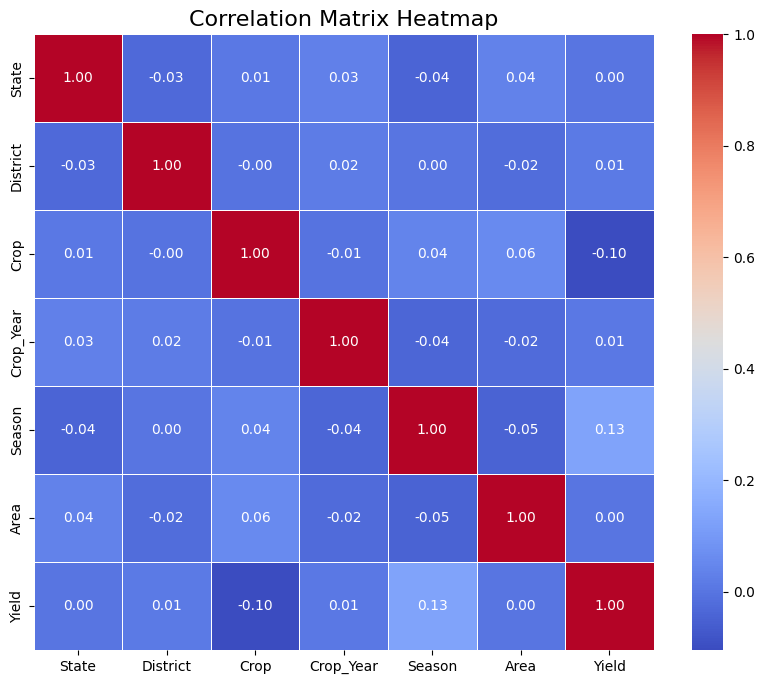

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [ ]:
x = Bidirectional(LSTM(32, return_sequences=True))(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=True))(x)

# Spatio-Temporal Attention Mechanism
attention = Dense(1, activation='tanh')(x)  # Shape: (batch_size, 6, 1)
attention = Flatten()(attention)  # Shape: (batch_size, 6)
attention = Activation('softmax')(attention)  # Shape: (batch_size, 6)
attention = RepeatVector(512)(attention)  # Shape: (batch_size, 512, 6)
attention = Permute([2, 1])(attention)  # Shape: (batch_size, 6, 512)

# Multiply attention with x
x = Multiply()([x, attention])  # Shape: (batch_size, 6, 512)

# Reshape to fit GRU input
x = Reshape((6, 512))(x)  # Shape: (batch_size, 6, 512)

# Replace the last two BiLSTM layers with GRU layers
x = GRU(128, return_sequences=True)(x)  # Shape: (batch_size, 6, 128)
x = GRU(64)(x)  # Shape: (batch_size, 64)

# Dense layers
x = Dense(64, activation='gelu')(x)
outputs = Dense(1)(x)

# Build the model
model = Model(inputs, outputs)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_absolute_error')


In [ ]:
batch_size = 32
epochs = 5
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 143s 19ms/step - loss: 77.0370 - val_loss: 78.6124
Epoch 2/5
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 139s 19ms/step - loss: 76.3006 - val_loss: 78.7401
Epoch 3/5
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 151s 21ms/step - loss: 75.5439 - val_loss: 78.8584
Epoch 4/5
6907/6907 ━━━━━━━━━━━━━━━━━━━━ 202s 21ms/step - loss: 78.3710 - val_loss: 78.6156
Epoch 5/5
5841/6907 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 76.2927

In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
'''mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
nrmse = rmse / (y_test.max() - y_test.min())'''

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
'''print(f"MAPE: {mape:.4f}%")
print(f"NRMSE: {nrmse:.4f}")'''

2159/2159 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
Mean Absolute Error (MAE): 80.13036064914932
Mean Squared Error (MSE): 937283.5872617513
Root Mean Squared Error (RMSE): 968.1340750442323
R-squared (R2): -0.006825877646069678


'print(f"MAPE: {mape:.4f}%")\nprint(f"NRMSE: {nrmse:.4f}")'